# Cerebellar Model of Pursuit Learning (Figure 8-10, Herzfeld et al.)
This set of functions and parameters defines a model of cerebellar learning based on behavioral data collected from two monkeys using smooth pursuit eye movements. The original behavioral data was collected by David Herzfeld in Stephen G. Libserger's laboratory at Duke University. The following model describes how a motor memory can be instantiated in the cerebellar cortex via cerebellar climbing fibers, resulting in plasticity at the parallel fiber to Purkinje cell synapse. This memory is then transferred out of the cerebellar cortex, affecting plasticity at the floccular target neurons in the vestibular nucleus (FTNs). The model defines the following:
<ul>
<li> Parallel fibers (two) which are linearly tuned for eye velocity in opposite directions. The response of the parallel fibers (in terms of absolute spk/s) are arbitrary.</li>
<li> A single Purkinje cell with a baseline firing rate (~50Hz). There exists a weight between the two parallel fibers and the Purkinje cell. This weight is adaptable.</li>
<li> A single floccular target neuron (FTN) in the vestibular nucleus which receives input the Purkinje cell. We assume that the FTNs encode the velocity of the eye (because they project to the motoneurons). </li>
<li> Secondary weighted inputs to the FTNs (which we call mossy fibers). These weights are adaptable. There are 100 mossy fiber inputs (50 with one preferred direction, 50 with opposite preferred directions) </li>
<li> The weighted inputs to the FTNs (mossy fibers) are adaptable via Hebbian style plasticity. </li>
</ul>

## Model implementation for Figures 8-10
The model in Figures 8-10 adds recurrent inibition in the circuit and learning at the parallel fiber to purkinje cell synapse. To get in the initial plot in Figure 8 (absent recurrent inhibition from the cerebellar output to the FTNs, simply set gamma (below) equal to zero.

## Standard import statements
The current code base depends on `PyPlot` (which, in turn, depends on the `PyCall` Julia package). These packages effectively call the Python interpreter behind the scenes to render the figures. If they these packages are not already installed, run `Pkg.add("PyPlot)` in the Julia REPL before running this model.

In [1]:
using PyPlot
using StatsBase

## Parameter definitions
This cell defines all of the parameters in Table 1. These parameters are used in the remaining functions. 

In [2]:
# What is the baseline firing rate of Purkinje cells ?
purkinje_cell_baseline_rate = 50

# Retention factor for parallel fibers
alpha = 0.85 

# Change parallel fiber to PC weights due to a complex spike
beta = 1.5 

# Rate constant transferring learning from Purkinje cells to FTN
eta = 2.5e-4 

# Inhibition of the olive
gamma = 75 # Set this equal to zero for Figure 8 (no inhibition)

# Standard deviation of Gaussian FTN input responses
sigma = 7.5

# Retention factor associated with learning at the mossy fiber inputs to the FTN
# We assume complete retention
mossy_fiber_alpha = 1

# Parallel fiber to Purkinje cell baseline weight value
w_0 = 1

# We call this C in table 1
ftn_scaling_to_velocity = 0.0625  # Scale by this number to convert to velocity

## Monkey specific parameters

# Probability of a complex spike given an error. Note: we scale this value by 2 to ensure that 
# the range is appropriate for complex spikes (peaks around 0.3 - 0.4 for a 30 deg/s instruction)
re_pr_cs(error::Real) = (1.3525109235041097 / (1 + 1.0000000000035258 * exp(-error * 0.20907290571921658)) - 0.6762554617520549) / 2
yo_pr_cs(error::Real) = (1.2467661595595918 / (1 + 1.000000000003952 * exp(-error * 0.11838097502159657)) - 0.6233830797797959) / 2

# Parallel fiber velocity (deg/s) to firing rate (Hz)
#re_parallel_fiber_speed_resp(eye_speed::Real) = (0.138083 + 0.0605737 * eye_speed) / 0.0666 #re_ftn_scaling_to_velocity
#yo_parallel_fiber_speed_resp(eye_speed::Real) = (-0.0556268 + 0.0535827 * eye_speed) / 0.0472 #yo_ftn_scaling_to_velocity

re_parallel_fiber_speed_resp(eye_speed::Real) = (0.0986 * eye_speed + 0.2248) / 0.1098 #re_ftn_scaling_to_velocity
yo_parallel_fiber_speed_resp(eye_speed::Real) = (0.1137 * eye_speed - 0.2248) / 0.10264  #yo_ftn_scaling_to_velocity


yo_parallel_fiber_speed_resp (generic function with 1 method)

### Parallel fiber response properties

In [3]:
# Parallel fiber properties (note: we assume two parallel fibers with opposite perferred directions)
parallel_fiber_preferred_directions = [0, pi]
number_of_parallel_fibers = length(parallel_fiber_preferred_directions)
parallel_fiber_weights = w_0 * ones(number_of_parallel_fibers)

"""Returns the response of a set of parallel fibers as a vector for a given eye speed"""
function parallel_fiber_response(eye_speed::Real)
    return cos.(parallel_fiber_preferred_directions) .* parallel_fiber_speed_resp(eye_speed)
end

"""Perform LTD at the parallel fibers given the size of the error

This function determines the probability of a complex spike occurring 
and performed LTD when both the parallel fiber and climbing fiber
fire simultaneously. In the absence of parallel fiber input/climbing
fiber input, the weights slowly decay back to their baseline levels
"""
function parallel_fiber_ltd!(parallel_fiber_weights::Vector, parallel_fiber_resp::Vector, error_size::Real, eye_speed::Real, ftn_resp::Real)
    for i = 1:length(parallel_fiber_weights)
        if parallel_fiber_resp[i] > 0
             parallel_fiber_weights[i] = parallel_fiber_weights[i] - (1 - alpha) * (parallel_fiber_weights[i] - 1) - beta * probability_complex_spike(error_size, eye_speed, ftn_resp)
        else
            parallel_fiber_weights[i] = parallel_fiber_weights[i] - (1 - alpha) * (parallel_fiber_weights[i] - 1)
        end
    end
    return parallel_fiber_weights
end

parallel_fiber_ltd!

### Mossy fiber response properties

In [4]:
# Mossy fiber properties. We assume there are 50 mossy fibers with different preferred speeds in each direction
mossy_fiber_preferred_speeds = (0:1:50)
mossy_fiber_preferred_directions = [0, pi]
number_of_mossy_fibers = length(mossy_fiber_preferred_speeds) * length(mossy_fiber_preferred_directions)
mossy_fiber_weights = ones(number_of_mossy_fibers)

"""Returns the response of selection of mossy fibers. Gaussian tuned for speed"""
function mossy_fiber_response(eye_speed::Real)
    response = zeros(number_of_mossy_fibers)
    for i = 1:length(mossy_fiber_preferred_directions)
        response[(i-1) * length(mossy_fiber_preferred_speeds) .+ (1:length(mossy_fiber_preferred_speeds))] = 
            cos(mossy_fiber_preferred_directions[i]) .* exp.(-(eye_speed .- mossy_fiber_preferred_speeds).^2 / (2 * sigma^2))
    end
    return response
end

"""Updates the mossy fiber weights based on the response of pre-synaptic FTNs.

Given the FTN response and the mossy fiber response, LTP occurs when the FTN and mosys fiber respond
simultaneously. Note that we assume this response is multiplicative (if the FTN and the mossy fiber response
MORE TOGETHER, more LTP occurs). As noted above, we current assume this change is permanent (mossy fiber alpha = 1).
"""
function mossy_fiber_ltp!(mossy_fiber_weights::Vector, mossy_fiber_resp::Vector, pc_resp::Real, error::Real)
    for i = 1:length(mossy_fiber_weights)
        if mossy_fiber_resp[i] > 0
            mossy_fiber_weights[i] = mossy_fiber_weights[i] - (1 - mossy_fiber_alpha) * (mossy_fiber_weights[i] - 1) + eta * mossy_fiber_resp[i] * (purkinje_cell_baseline_rate - pc_resp)
        end
    end
    return mossy_fiber_weights
end

mossy_fiber_ltp!

### Purkinje cell response properties (including complex spikes)

In [5]:
"""Returns the purkinje cell response, which is the sum of the weighted parallel fiber inputs + its baseline response"""
function purkinje_cell_response(parallel_firing::Vector, parallel_weights::Vector)
    return sum(parallel_firing .* parallel_weights) + purkinje_cell_baseline_rate
end

"""Returns the probability of a complex spike given the error magnitude.

NOTE: This function assumes that the error is in the PC's preferred direction. This function
also implements the recurrent inhibition of the olive by the FTN response (which is why it takes
the FTN response as a parameter). The inhibition of the olive affects the perceived error magnitude.
"""
function probability_complex_spike(error_magnitude::Real, eye_speed::Real=20, FTN_response::Real=0)
    error_magnitude = error_magnitude - (gamma * FTN_response * ftn_scaling_to_velocity / eye_speed)
    #cs = 0.60 / (1 + exp(-error_magnitude .* 0.10)) - 0.30
    cs = pr_cs(error_magnitude)
    return (cs < 0 ? 0 : cs)
end

probability_complex_spike

### FTN (Vestibular nucleus neuron) response properties

In [6]:
"""Returns the FTN response in spk/s. 

The FTN response is the weighted sum of mossy fiber inputs and the
change in the PC response from its baseline level. This makes the
inherent assumption that the balance of excitation and inhibition
is roughly balanced at the FTN before learning (i.e., the FTN is
not dramatically inhibited by the standard firing of pre-synaptic
Purkinje cells as 50Hz).
"""
function ftn_response(mossy_fiber_firing, mossy_weights, pc_resp)
   return sum(mossy_fiber_firing .* mossy_weights) - pc_resp + purkinje_cell_baseline_rate
end

ftn_response

In [7]:
"""Define a function which runs the simulation

When the function is called it runs a simulation with `num_trials` learning trials
with the passed `pursuit_speed`. The function plots the behavioral responses if a 
probe trial with a different pursuit speed occurred after each trial.

Parameters:
  - pursuit_speed[required]: The speed of the target in the pursuit direction in the learning trials
  - num_trials (defaults to 1000): The number of learning trials to probe
  - instruction_speed (defaults to 30 deg/s): The magnitude of the instructive stimulus in the learning
    direction in each learning trial.
  - probe_speeds (defaults to 5, 10, 15, 20 deg/s): A vector of pursuit speeds used in the probe trials (tested)
    after each learning trial in the run. 
"""
function run_multi_trial_learning_simulation(instruction_speeds::AbstractVector{<:Real}; pursuit_speed::Real=20)
    # Ensure that our plastic weights (parallel fibers and mossy fibers)
    # are reset after the last run.
    global parallel_fiber_weights = w_0 * ones(number_of_parallel_fibers)
    global mossy_fiber_weights = ones(number_of_mossy_fibers)
    learned_response = zeros(length(instruction_speeds))
    for i = 1:length(instruction_speeds)
        # Determine the response of the parallel fibers at the learning pursuit speed 
        # Vector with length 2
        pf = parallel_fiber_response(pursuit_speed)

        # Determine the Purkinje cell response given the current parallel fiber weights
        # and responses
        # Returns a single Real
        pc = purkinje_cell_response(pf, parallel_fiber_weights)

        # Determine the response of the population of mossy fibers for the learning pursuit
        # speed. Returns a vector of length 100
        mf = mossy_fiber_response(pursuit_speed)

        # Now that we know the PC and the mossy fiber response, we can calculate the 
        # FTN response on the current trial (sum of weighted mossy fiber inputs and the
        # change in the PC input from baseline).
        # Returns a single Real
        ftn = ftn_response(mf, mossy_fiber_weights, pc)
        learned_response[i] = ftn

        # Compute the retinal error used to drive learning in the cerebellar cortex
        # The error is the difference between the FTN response (scaled to units of velocity)
        # and the imposed instruction. 
        # A single Real
        error = instruction_speeds[i] - ftn * ftn_scaling_to_velocity

        # Given the responses of the mossy fibers and FTN, determine how the mossy
        # fiber weights change for the next trial
        mossy_fiber_ltp!(mossy_fiber_weights, mf, pc, error)

        # Given the magnitude of the error, determine how the parallel fiber
        # weight change on the next trial
        parallel_fiber_ltd!(parallel_fiber_weights, pf, error, pursuit_speed, ftn) # ftn
    end
    return learned_response
end

function run_multi_trial_learning_simulation_vs_instruction_speeds(;instruction_speeds::AbstractVector{<:Real}=[0, 5, 10, 15, 20, 25, 30], num_trials::Integer=100, num_baseline_trials::Integer=0, monkey::AbstractString="RE", pursuit_speed::Real=20, fig=nothing)
    if monkey == "RE"
        global pr_cs = re_pr_cs
        global parallel_fiber_speed_resp = re_parallel_fiber_speed_resp
    else
        global pr_cs = yo_pr_cs
        global parallel_fiber_speed_resp = yo_parallel_fiber_speed_resp
    end
    
    learned_response = zeros(length(instruction_speeds), num_trials)
    for (i, instruction_speed) = enumerate(instruction_speeds)
       learned_response[i, :] = run_multi_trial_learning_simulation(ones(num_trials) .* instruction_speed, pursuit_speed=pursuit_speed)
    end
    
    # Plot the responses to the probes (scaling to units of velocity)
    if fig == nothing
        fig = figure();
    else
        sca(fig[:gca]())
    end
    for i = 1:length(instruction_speeds)
        plot(1:num_trials + num_baseline_trials, vcat(zeros(num_baseline_trials), learned_response[i, :] .* ftn_scaling_to_velocity), label=string(instruction_speeds[i], " deg/s")) 
    end
    #plot(instruction_speeds, dropdims(mean(learned_response[:, end-25:end] .* ftn_scaling_to_velocity, dims=2), dims=2)) 
    title(string("Monkey ", monkey))
    legend()
    xlabel("Trial")
    ylabel("Learned response (deg/s)")
    return fig
end

run_multi_trial_learning_simulation_vs_instruction_speeds (generic function with 1 method)

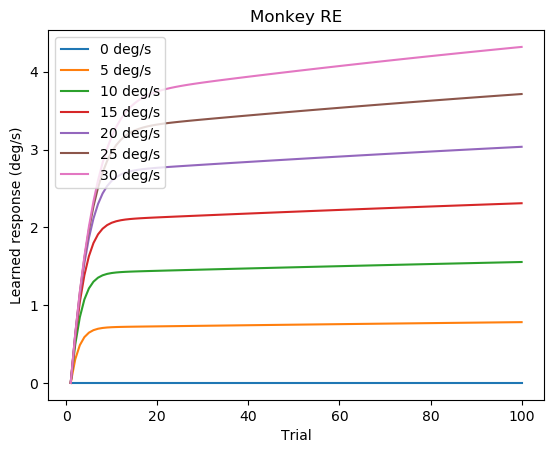

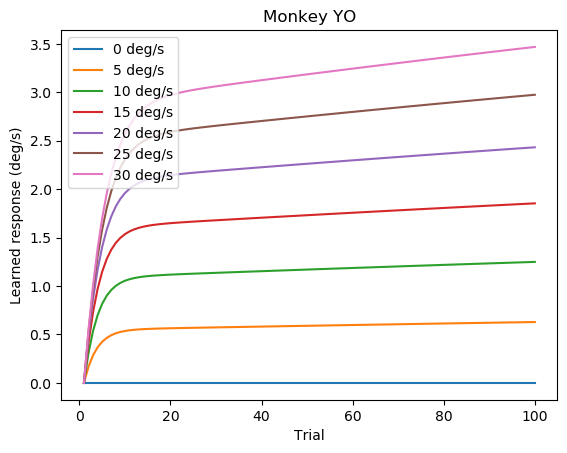

In [8]:
using PrettyPlot
run_multi_trial_learning_simulation_vs_instruction_speeds(monkey="RE", num_trials=100)
run_multi_trial_learning_simulation_vs_instruction_speeds(monkey="YO");

In [9]:
"""Define a function which runs the simulation

When the function is called it runs a simulation with `num_trials` learning trials
with the passed `pursuit_speed`. The function plots the behavioral responses if a 
probe trial with a different pursuit speed occurred after each trial.

Parameters:
  - pursuit_speed[required]: The speed of the target in the pursuit direction in the learning trials
  - num_trials (defaults to 1000): The number of learning trials to probe
  - instruction_speed (defaults to 30 deg/s): The magnitude of the instructive stimulus in the learning
    direction in each learning trial.
  - probe_speeds (defaults to 5, 10, 15, 20 deg/s): A vector of pursuit speeds used in the probe trials (tested)
    after each learning trial in the run. 
"""
function run_simulation(pursuit_speed::Real; num_trials::Integer=1000, instruction_speed::Real=30, probe_speeds::AbstractVector{<:Real}=[5, 10, 15, 20])
    # Ensure that our plastic weights (parallel fibers and mossy fibers)
    # are reset after the last run.
    global parallel_fiber_weights = w_0 * ones(number_of_parallel_fibers)
    global mossy_fiber_weights = ones(number_of_mossy_fibers)
    
    # Define the output vectors. Responses for FTNs, Purkinje cells, and Mossy fibers
    # and behavior across all probes
    ftn_output = zeros(num_trials)
    pc_output = zeros(num_trials)
    mf_output = zeros(num_trials)
    probe_output = zeros(length(probe_speeds), length(ftn_output))

    # Loop over trials
    for i = 1:num_trials
        # Determine the response of the parallel fibers at the learning pursuit speed 
        # Vector with length 2
        pf = parallel_fiber_response(pursuit_speed)
        
        # Determine the Purkinje cell response given the current parallel fiber weights
        # and responses
        # Returns a single Real
        pc = purkinje_cell_response(pf, parallel_fiber_weights)
        
        # Determine the response of the population of mossy fibers for the learning pursuit
        # speed. Returns a vector of length 100
        mf = mossy_fiber_response(pursuit_speed)
        
        # Now that we know the PC and the mossy fiber response, we can calculate the 
        # FTN response on the current trial (sum of weighted mossy fiber inputs and the
        # change in the PC input from baseline).
        # Returns a single Real
        ftn = ftn_response(mf, mossy_fiber_weights, pc)
        
        # Compute the retinal error used to drive learning in the cerebellar cortex
        # The error is the difference between the FTN response (scaled to units of velocity)
        # and the imposed instruction. 
        # A single Real
        error = instruction_speed - ftn * ftn_scaling_to_velocity

        # Store our computed values in the output array
        ftn_output[i] = ftn
        pc_output[i] = pc
        mf_output[i] = sum(mf .* mossy_fiber_weights)

        # Given the responses of the mossy fibers and FTN, determine how the mossy
        # fiber weights change for the next trial
        mossy_fiber_ltp!(mossy_fiber_weights, mf, pc, error)
        
        # Given the magnitude of the error, determine how the parallel fiber
        # weight change on the next trial
        parallel_fiber_ltd!(parallel_fiber_weights, pf, error, pursuit_speed, ftn) # ftn

        # Now that we have our adapted weights, compute the response of all of the 
        # probes if they were to occur after this learning trial. Note: we don't 
        # do any plasticity here, because we are simply asking what would have 
        # happened if we had done any of these probes.
        for j = 1:length(probe_speeds)
            mf = mossy_fiber_response(probe_speeds[j])
            pf = parallel_fiber_response(probe_speeds[j])
            pc = purkinje_cell_response(pf, parallel_fiber_weights)
            ftn = ftn_response(mf, mossy_fiber_weights, pc)
            probe_output[j, i] = ftn
        end # End loop over probes
    end # End loop over trials

    # Plot the responses of the neural elements.
    figure();
    plot((1:length(ftn_output)) * 2, ftn_output, label="FTN")
    plot((1:length(ftn_output)) * 2, pc_output, label="Purkinje cell")
    plot((1:length(ftn_output)) * 2, mf_output, label="Mossy fiber")
    legend()
    xlabel("Trial")
    ylabel("Firing rate (Hz)")
    title("Response of neural elements")

    # Plot the responses to the probes (scaling to units of velocity)
    figure();
    for i = 1:length(probe_speeds)
       plot((1:length(ftn_output)) * 2, probe_output[i, :] * ftn_scaling_to_velocity, label=string(probe_speeds[i])) 
    end
    legend()
    xlabel("Trial")
    ylabel("Probe response")
    title("Behavioral response")
    return nothing
end

run_simulation

## Results

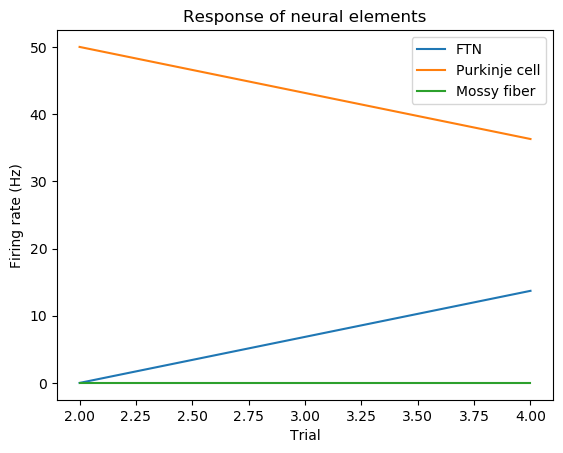

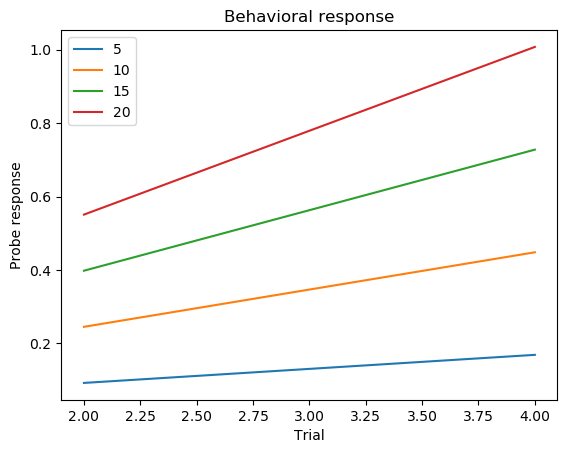

In [10]:
# Run the simulation for a single trial with various pursuit speeds
run_simulation(30,  num_trials=2)

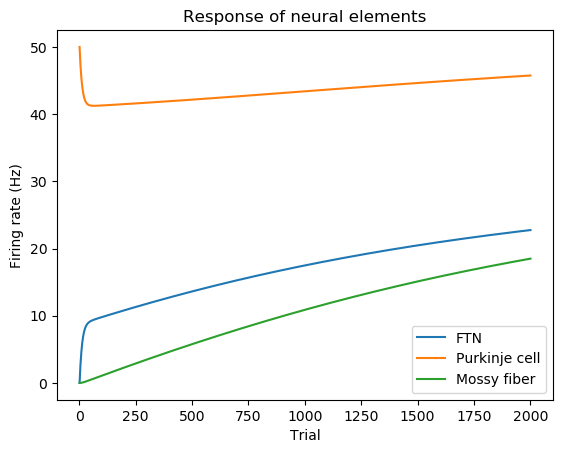

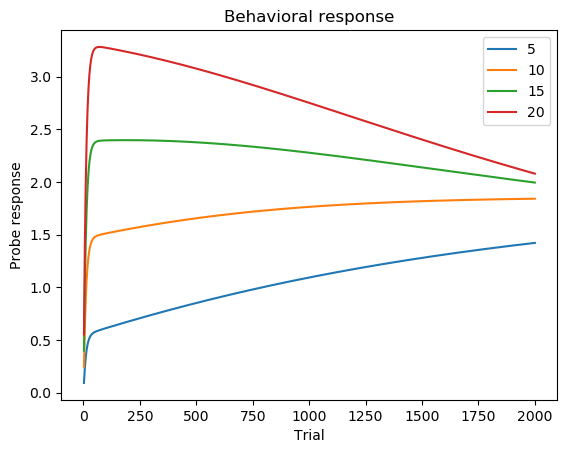

In [11]:
# Run the simulation for a training pursuit speed of 5 deg/s
run_simulation(5)

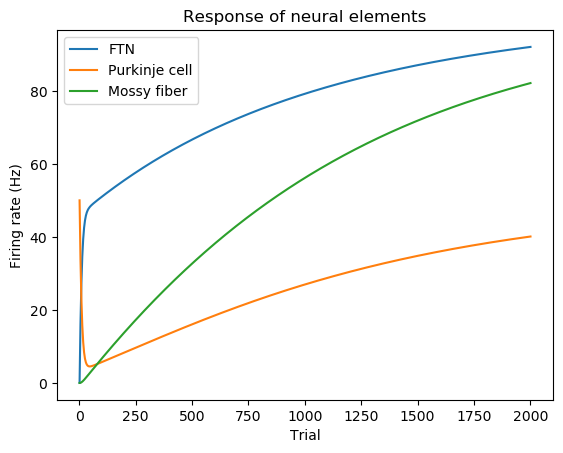

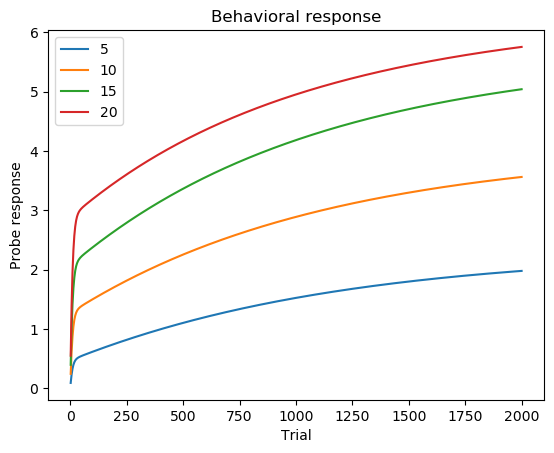

In [12]:
# Run the simulation for a training pursuit speed of 20 deg/s
run_simulation(20)